In [51]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import scipy.stats as stats

In [52]:
train_start = '2020-01-01'
train_end = '2023-12-31'
ticker = "JPY=X"

data = yf.download(ticker, start=train_start, end=train_end).dropna()
print("Historical data sample:")
print(data.head())

forecast_start = '2024-01-01'
forecast_end = '2025-04-15'
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='B')

actual_data = yf.download(ticker, start=forecast_start, end=forecast_end).dropna()
actual_prices = actual_data['Close']

n_steps = len(forecast_dates)
print("\nForecast date range:")
print(forecast_dates)
print("Number of forecast business days:", n_steps)

prices = data['Close']
log_returns = np.log(prices / prices.shift(1)).dropna()

trading_days = 252

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Historical data sample:
Price            Close        High         Low        Open Volume
Ticker           JPY=X       JPY=X       JPY=X       JPY=X  JPY=X
Date                                                             
2020-01-01  108.681000  111.410004  108.629997  108.680000      0
2020-01-02  108.712997  108.860001  108.221001  108.713997      0
2020-01-03  108.542999  108.551003  107.915001  108.540001      0
2020-01-06  107.963997  108.410004  107.921997  107.999001      0
2020-01-07  108.405998  108.616997  108.261002  108.411003      0

Forecast date range:
DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12',
               ...
               '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-07',
               '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11',
               '2025-04-14', '2025-04-15'],
              dtype='datetime64[ns]'

In [53]:
mu_annual = log_returns.mean() * trading_days
sigma_annual = log_returns.std() * np.sqrt(trading_days)
print("Estimated annual drift (mu):", mu_annual)
print("Estimated annual volatility (sigma):", sigma_annual)

def simulate_gbm(S0, mu, sigma, dt, n_steps, n_paths):
    paths = np.empty((n_steps, n_paths))
    paths[0, :] = S0

    for t in range(1, n_steps):
        for j in range(n_paths):
            Z = np.random.standard_normal()
            paths[t, j] = paths[t-1, j] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

n_simulations = 10
S0_value = prices.iloc[-1]
dt = 1 / trading_days

gbm_simulated_paths = simulate_gbm(S0_value, mu_annual, sigma_annual, dt, n_steps, n_simulations)
print("Simulated paths shape:", gbm_simulated_paths.shape)

gbm_simulations_df = pd.DataFrame(gbm_simulated_paths, index=forecast_dates)

/var/folders/sc/0qshmdq54w9600rz5brxjb3c0000gn/T/ipykernel_13970/3379641980.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  paths[t, j] = paths[t-1, j] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)


Estimated annual drift (mu): Ticker
JPY=X    0.063698
dtype: float64
Estimated annual volatility (sigma): Ticker
JPY=X    0.090677
dtype: float64
Simulated paths shape: (337, 10)


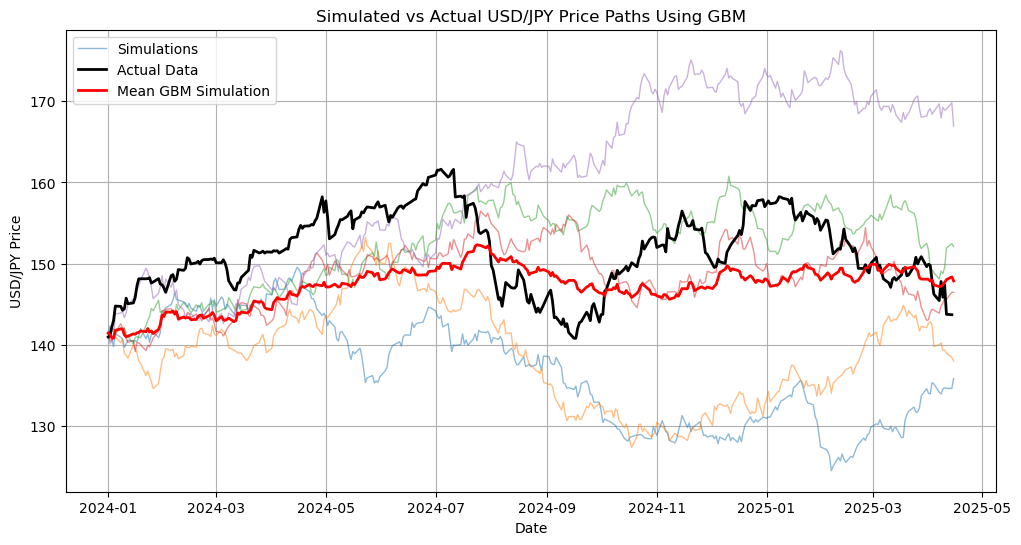

In [54]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(gbm_simulations_df.index, gbm_simulations_df.iloc[:, i], lw=1, alpha=0.5, label='Simulations' if i == 0 else "")

gbm_mean = gbm_simulations_df.iloc[:, :5].mean(axis=1)

plt.plot(actual_prices.index, actual_prices, color='black', lw=2, label='Actual Data')
plt.plot(gbm_mean.index, gbm_mean, color='red', lw=2, label='Mean GBM Simulation')
plt.title("Simulated vs Actual USD/JPY Price Paths Using GBM")
plt.xlabel("Date")
plt.ylabel("USD/JPY Price")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
def simulate_ou(S0, theta, mu, sigma, dt, n_steps, n_paths):
    paths = np.empty((n_steps, n_paths))
    paths[0, :] = S0
    for t in range(1, n_steps):
        for j in range(n_paths):
            paths[t, j] = paths[t-1, j] + theta * (mu - paths[t-1, j]) * dt + sigma * np.sqrt(dt) * np.random.standard_normal()
    return paths

delta = prices.diff().dropna()
lag_prices = prices.shift(1).dropna().loc[delta.index]
lag_prices_array = np.asarray(lag_prices).flatten()
delta_array = np.asarray(delta).flatten()
coeffs = np.polyfit(lag_prices_array, delta_array, 1)
b = coeffs[0]
a = coeffs[1]
theta_est = -b / dt
mu_est = a / (theta_est * dt)
residuals = delta_array - (a + b * lag_prices_array)
sigma_est = np.std(residuals) / np.sqrt(dt)
print("Estimated theta:", theta_est)
print("Estimated mu:", mu_est)
print("Estimated sigma:", sigma_est)
n_steps = len(forecast_dates)
n_simulations = 1000

ou_simulated_paths = simulate_ou(S0_value, theta_est, mu_est, sigma_est, dt, n_steps, n_simulations)
ou_simulations_df = pd.DataFrame(ou_simulated_paths, index=forecast_dates)

Estimated theta: 0.1828306784044685
Estimated mu: 165.4017828190439
Estimated sigma: 11.683736269281937


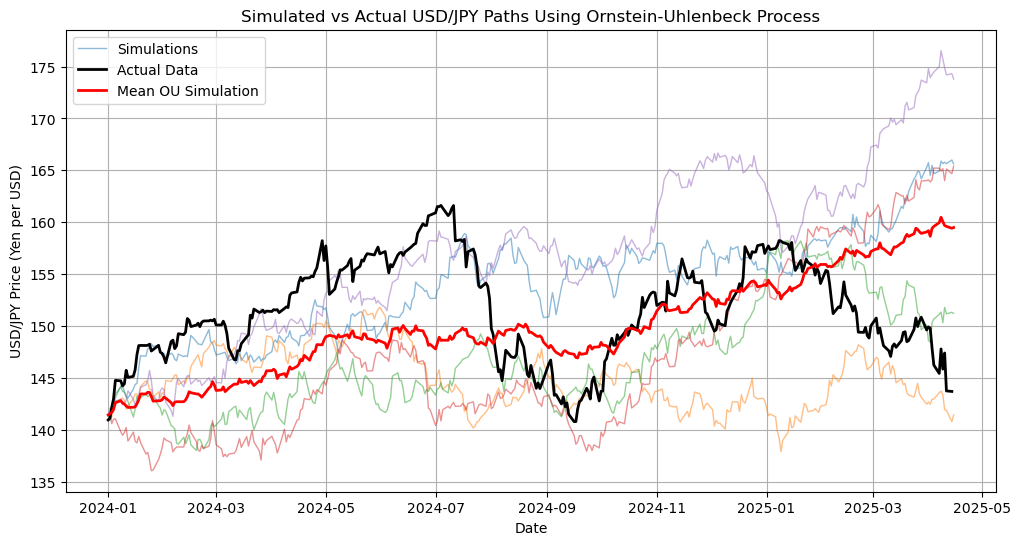

In [56]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.plot(ou_simulations_df.index, ou_simulations_df.iloc[:, i], lw=1, alpha=0.5, label='Simulations' if i == 0 else "")

ou_mean = ou_simulations_df.iloc[:, :5].mean(axis=1)

plt.plot(actual_prices.index, actual_prices, color='black', lw=2, label='Actual Data')
plt.plot(ou_mean.index, ou_mean, color='red', lw=2, label='Mean OU Simulation')
plt.title("Simulated vs Actual USD/JPY Paths Using Ornstein-Uhlenbeck Process")
plt.xlabel("Date")
plt.ylabel("USD/JPY Price (Yen per USD)")
plt.legend()
plt.grid(True)
plt.show()

In [58]:
model = arch_model(log_returns, mean='constant', vol='GARCH', p=1, q=1, dist='normal')
model_fit = model.fit(disp='off')
mu_est = model_fit.params['mu']
omega_est = model_fit.params['omega']
alpha_est = model_fit.params['alpha[1]']
beta_est = model_fit.params['beta[1]']
initial_sigma2 = model_fit.conditional_volatility[-1]**2
prices_sim = np.empty((n_steps, n_simulations))
sigmas = np.empty((n_steps, n_simulations))
returns_sim = np.empty((n_steps, n_simulations))
prices_sim[0, :] = S0_value
sigmas[0, :] = np.sqrt(initial_sigma2)
returns_sim[0, :] = 0

for t in range(1, n_steps):
    for j in range(n_simulations):
        z = np.random.standard_normal()
        r = mu_est + sigmas[t-1, j] * z
        returns_sim[t, j] = r
        prices_sim[t, j] = prices_sim[t-1, j] * np.exp(r)
        sigmas[t, j] = np.sqrt(omega_est + alpha_est * (sigmas[t-1, j] * z)**2 + beta_est * sigmas[t-1, j]**2)

garch_simulations_df = pd.DataFrame(prices_sim, index=forecast_dates)

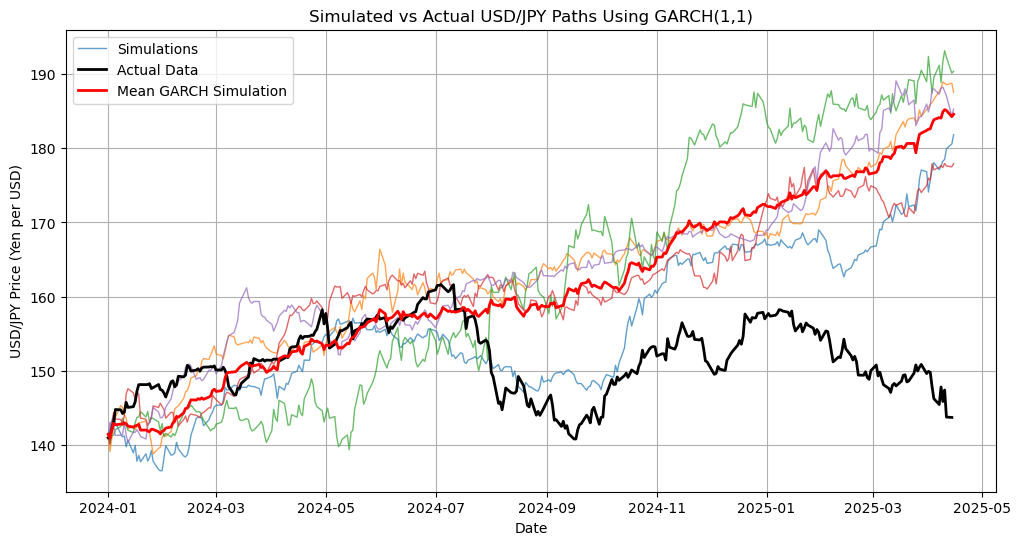

In [59]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.plot(garch_simulations_df.index, garch_simulations_df.iloc[:, i], lw=1, alpha=0.7, label='Simulations' if i==0 else "")

garch_mean = garch_simulations_df.iloc[:, :5].mean(axis=1)

plt.plot(actual_prices.index, actual_prices, color='black', lw=2, label='Actual Data')
plt.plot(garch_mean.index, garch_mean, color='red', lw=2, label='Mean GARCH Simulation')
plt.title("Simulated vs Actual USD/JPY Paths Using GARCH(1,1)")
plt.xlabel("Date")
plt.ylabel("USD/JPY Price (Yen per USD)")
plt.legend()
plt.grid(True)
plt.show()

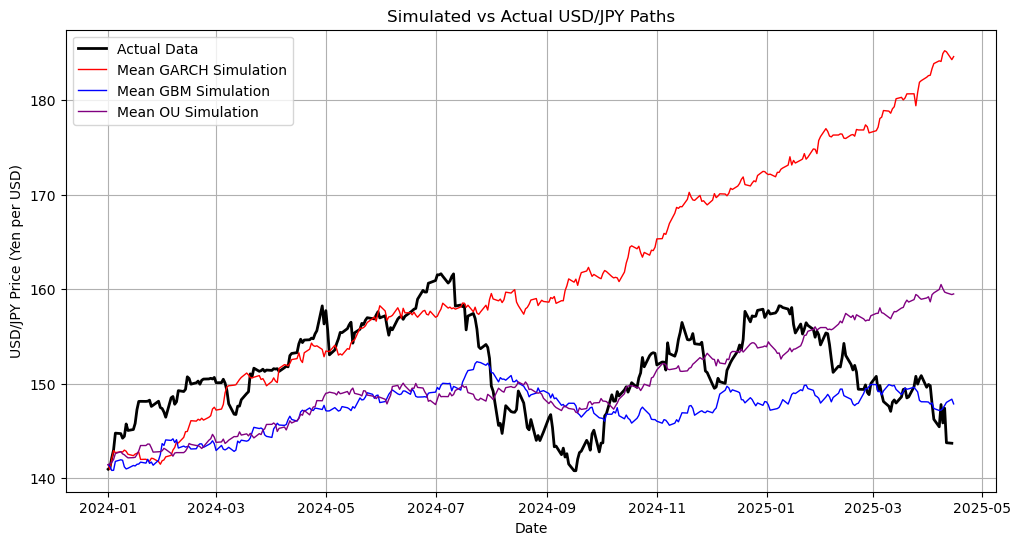

In [60]:
plt.figure(figsize=(12,6))
plt.plot(actual_prices.index, actual_prices, color='black', lw=2, label='Actual Data')
plt.plot(garch_mean.index, garch_mean, color='red', lw=1, label='Mean GARCH Simulation')
plt.plot(gbm_mean.index, gbm_mean, color='blue', lw=1, label='Mean GBM Simulation')
plt.plot(ou_mean.index, ou_mean, color='purple', lw=1, label='Mean OU Simulation')
plt.title("Simulated vs Actual USD/JPY Paths")
plt.xlabel("Date")
plt.ylabel("USD/JPY Price (Yen per USD)")
plt.legend()
plt.grid(True)
plt.show()

In [61]:
actual_log_returns = np.log(actual_prices / actual_prices.shift(1)).dropna().values.ravel()
gbm_sim_log_returns = np.diff(np.log(gbm_simulations_df.values), axis=0).flatten()
ou_sim_log_returns = np.diff(np.log(ou_simulations_df.values), axis=0).flatten()
garch_sim_log_returns = np.diff(np.log(garch_simulations_df.values), axis=0).flatten()

all_returns = np.concatenate([
    actual_log_returns,
    gbm_sim_log_returns,
    ou_sim_log_returns,
    garch_sim_log_returns
])

min_val = np.min(all_returns)
max_val = np.max(all_returns)
n_bins = 20
bins = np.linspace(min_val, max_val, n_bins + 1)

obs_counts, _ = np.histogram(actual_log_returns, bins=bins)
gbm_counts, _ = np.histogram(gbm_sim_log_returns, bins=bins)
ou_counts, _ = np.histogram(ou_sim_log_returns, bins=bins)
garch_counts, _ = np.histogram(garch_sim_log_returns, bins=bins)

n_obs = len(actual_log_returns)
gbm_expected = gbm_counts / len(gbm_sim_log_returns) * n_obs
ou_expected = ou_counts / len(ou_sim_log_returns) * n_obs
garch_expected = garch_counts / len(garch_sim_log_returns) * n_obs

def chi_squared_statistic(observed, expected):
    nonzero = (expected > 0)
    return np.sum((observed[nonzero] - expected[nonzero])**2 / expected[nonzero])

chi2_gbm = chi_squared_statistic(obs_counts, gbm_expected)
chi2_ou  = chi_squared_statistic(obs_counts, ou_expected)
chi2_garch = chi_squared_statistic(obs_counts, garch_expected)

dof = n_bins - 2 - 1
p_val_gbm = 1 - stats.chi2.cdf(chi2_gbm, dof)
p_val_ou = 1 - stats.chi2.cdf(chi2_ou, dof)
p_val_garch = 1 - stats.chi2.cdf(chi2_garch, dof)

print("Chi-Squared Statistics and p-values for the Forecast Returns Distribution:")
print("GBM:    Chi2 = {:.2f}, p-value = {:.4f}".format(chi2_gbm, p_val_gbm))
print("OU:     Chi2 = {:.2f}, p-value = {:.4f}".format(chi2_ou, p_val_ou))
print("GARCH:  Chi2 = {:.2f}, p-value = {:.4f}".format(chi2_garch, p_val_garch))

Chi-Squared Statistics and p-values for the Forecast Returns Distribution:
GBM:    Chi2 = 108.49, p-value = 0.0000
OU:     Chi2 = 646.15, p-value = 0.0000
GARCH:  Chi2 = 21.14, p-value = 0.2199
